## La vida del data scientist

El equipo de marketing de la empresa X quiere tomar decisiones para alocar presupuesto en base al valor futuro de los usuarios. Para ello se nos ha encargado desarrollar un modelo de LTV(file time value) que consista en predecir el valor futuro de cada usuario.

Debido a que esta problematica es compleja, vamos a dividir el problema en 3 partes:
- 1- Vamos a predecir si el usuario va a churnear (no va a comprar en el próximo año)

- 2- Vamos a hacer un analisis clasico llamado RFM para entender como se segmentan nuestros usuarios

- 3- Vamos a ponerle un valor a la cantidad de compras que realizará a futuro

Para ello, se nos ha proporcionado un dataset -que afortunadamente nos dejaron los datos limpios (esto solo pasa en la facultad jeje)- para que podamos entrenar nuestro modelo. 

El datset consiste en los siguientes campos:
- cust: ID del usuarios
- Freq_2Y: Dias distintos de pago en ultimos 2 años
- Freq_1Y: Dias distintos de pago en ultimos 1 años
- Freq_3M: Dias distintos de pago en ultimos 3 meses
- Recency: Cantidad de dias desde ultima compra
- first_in_windows: Cantidad de dias desde primer compra
- IPT_mean: Intervalo entre compra y compra
- CREDIT_PAY: Pagos con tarjeta de credito
- TIPO_TARJETA
- CUS_FIRST_BUY: Dias desde primer compra
- CANTIDAD_COMPRAS_ITEMS_USADOS
- cant_dias_active_short: dias distintos de visita al sitio
- recency_date_short: Dias desde ultima visita
- Frequency_target: Dias distinto de compra en el próximo año

## 1) Levantamos el dataset

In [4]:
import pandas as pd
dataset = pd.read_csv("DATASET_LTV.csv") # Levantamos el dataset

# dataset.head()  # Siempre que levantamos un archivo vemos levantamos ;)

#### Es coherente lo que vemos? 
Pista: Usa el parametro sep

In [5]:
dataset = pd.read_csv("DATASET_LTV.csv",sep = ";")
dataset.head()

,cust,Recency,first_in_windows,Freq_2Y,Freq_1Y,Freq_3M,IPT_mean,CREDIT_PAY,TIPO_TARJETA,CUS_FIRST_BUY,CANTIDAD_COMPRAS_ITEMS_USADOS,cant_dias_active_short,recency_date_short,Frequency_target
0,378518804,294.0,294.0,1,1,0.0,9.999999e+06,1.0,2.0,294.0,0,0.0,9999999.0,0.0
1,389613070,4.0,4.0,1,1,1.0,9.999999e+06,0.0,0.0,4.0,0,0.0,9999999.0,0.0
2,56668186,42.0,545.0,9,8,2.0,1.304561e+00,8.0,4.0,3114.0,0,1.0,27.0,14.0
3,307374346,14.0,544.0,6,5,1.0,1.301598e+00,7.0,2.0,544.0,0,3.0,1.0,6.0
4,211220646,31.0,48.0,3,3,3.0,9.097720e-01,0.0,0.0,48.0,0,5.0,16.0,1.0


# 2) SEGMENTANDO LA BASE DE USUARIOS
Vamos a aplicar K means sobre la base de usuarios para ver si encontramos segmentos de usuarios. Para ello vamos a usar los campos Recency, first_in_windows,Freq_2Y. Esta técnica se conoce como RFM y es muy usada en marketing.

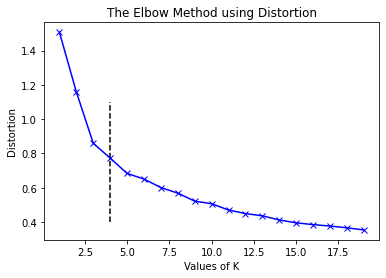

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
import numpy as np

# hacemos todo de una. Llamo al modelo standard scaler y despues entreno y transformo en un mismo paso
# Como estamos explorando nada mas, no importa nos separamos testing y training.
X_cluster = StandardScaler().fit_transform(dataset[["Recency","first_in_windows","Freq_2Y"]]) 

# Ahora su turno. Hay que calcular cual es la cantidad optima de clusters usando el metodo del codo. Recordemos que tenemos que interpretar los resultados despues!
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

distortions = []
for k in range(1,20):
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,n_jobs=-1)
    kmeanModel.fit(X_cluster)     
    
    distortions.append(sum(np.min(cdist(X_cluster, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X_cluster.shape[0]) 

plt.plot(list(range(1,20)), distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

plt.vlines(x = 4,ymin=0.4,ymax=1.1,linestyles="dashed",color="black")

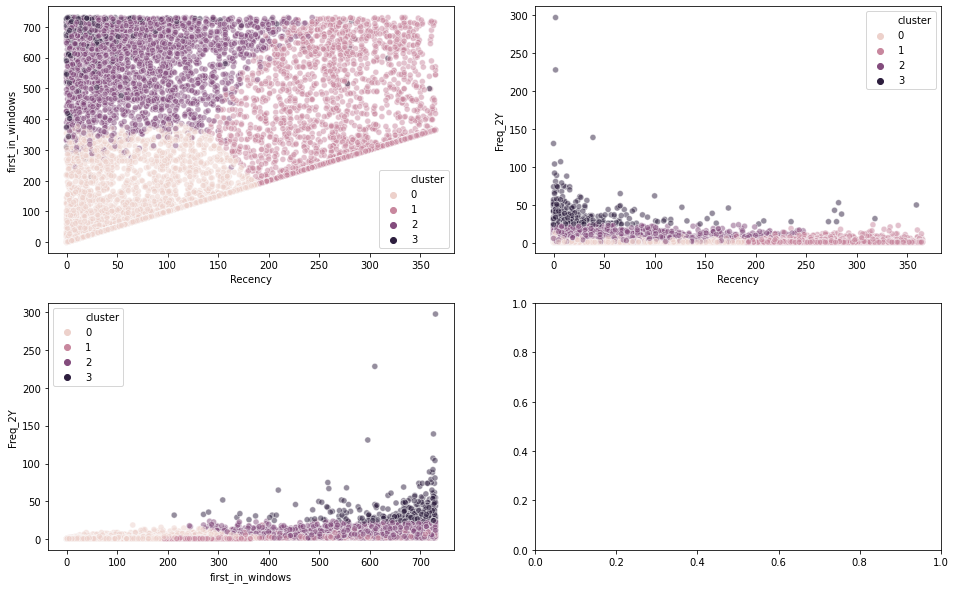

In [21]:
import seaborn as sns

OPTIMAL_K = 4 # del metodo del codo aprendimos que una cuena cantidad de clusters interpretables es de 4
kmean = KMeans(n_clusters=OPTIMAL_K,n_jobs=-1) # instancio el modelo
kmean.fit(X_cluster) # entreno
dataset["cluster"] = kmean.predict(X_cluster) # aplico

fig, axs = plt.subplots(2, 2,figsize=(16,10))

sns.scatterplot(
    x="Recency", y="first_in_windows",
    hue="cluster",
    data=dataset,
    legend="full",
    alpha=0.5,
    ax = axs[0,0]
)

sns.scatterplot(
    x="first_in_windows", y="Freq_2Y",
    hue="cluster",
#     palette=sns.color_palette("hls", 10),
    data=dataset,
    legend="full",
    alpha=0.5,
    ax = axs[1,0]
)

sns.scatterplot(
    x="Recency", y="Freq_2Y",
    hue="cluster",
#     palette=sns.color_palette("hls", 10),
    data=dataset,
    legend="full",
    alpha=0.5,
    ax = axs[0,1]
)

Bueno ya con esta segmentación bastante sencilla podemos ejecutar distintas estrategias de marketing dependiendo de los segmentos de usuarios. Los usuarios frecuentes, que compraron hace poco y estan desde hace mucho son los mejores. Los que compraron una vez hace mucho tiempo y nunca mas volvieron son nuestros peores usuarios, vamos a tener que gastarnos mucha plata para recuperarlos y el retorno que nos dejarán es bajo...

# 3) Forecast

Pero no nos conformamos con una segmentación, si bien es de mucha utlidad para explicar a la gerencia, nosotros queremos ir mas alla y poder decir para cada usuario cuanto valor generará a futuro. Para ello vamos a usar el campo Frequency_target que contiene la cantidad de días distintos de compra en el próximo año

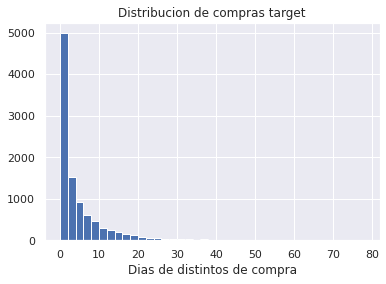

In [32]:
# Antes de empezar a modelar, veamos como se distribuye nuestro target
# Hay mucha concentracion de valores nulos y bajos, y por otro lado valores muy extremos. 
# Estos valores extremos tambien son importantes de detectar ya que unos pocos generan mucho y unos muchos generan poco.
# El MAE va a ser una metrica que vaya mejor para este caso ya que vamos a estar trabajando mucho con valores chicos

sns.set(font_scale = 1)
plt.hist(dataset.Frequency_target,bins=range(0,80,2))
plt.xlabel("Dias de distintos de compra")
_ = plt.title("Distribucion de compras target")

MAE =  $\frac{1}{n} \sum |x_i - \hat{x_i}| $

MSE = $\frac{1}{n} \sum |x_i - \hat{x_i}|^2 $

In [61]:
# Lo primero que hacemos es separarnos test de control
from sklearn.model_selection import train_test_split

train_cols = ['Recency', 'first_in_windows', 'Freq_2Y', 'Freq_1Y', 'Freq_3M',
       'IPT_mean', 'CREDIT_PAY', 'TIPO_TARJETA',
       'CUS_FIRST_BUY', 'CANTIDAD_COMPRAS_ITEMS_USADOS',
       'cant_dias_active_short', 'recency_date_short']

# Esta vez vamos a complejizarlo mas, vamos a necesitar un trani - validation -test
# Porque usamos validation ahora? Las redes neuronales necesitan "cortar" antes de tiempo para no aprender de mas
# Esto se conoce como early stopping, tambien se usa mucho en modelos de boosting mas complejos como XGBoost y sus primos-hermanos...

# Vamos a hacer 70 - 30
X_train, X_test, y_train, y_test  = train_test_split(dataset[train_cols],dataset.Frequency_target,random_state=42,test_size = 0.3) 

In [41]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [100, 30, 10, 5, 1, 0.1, .01, 0.001]}

# Hacer la busqueda 
search_lasso=GridSearchCV(Lasso(),param_grid,cv=3,n_jobs=-1,scoring="neg_mean_absolute_error")
search_lasso.fit(X_train,y_train)

# Lasso nos deja ver que coeficientes fueron llevados a 0, esto nos da una noción de features irrelevantes

aux = search_lasso.best_estimator_.coef_

for i in range(len(aux)):
  print("Feature: {} | Parameter: {}".format(aux[i],train_cols[i]))


Feature: -0.0016372760558568047 | Parameter Recency
Feature: 0.0030940660892789973 | Parameter first_in_windows
Feature: 0.08368624032385595 | Parameter Freq_2Y
Feature: 0.508571789086248 | Parameter Freq_1Y
Feature: 1.0804220929817243 | Parameter Freq_3M
Feature: 1.1376676952504247e-08 | Parameter IPT_mean
Feature: -0.021631491788045992 | Parameter CREDIT_PAY
Feature: 0.320382387895756 | Parameter TIPO_TARJETA
Feature: 0.00031986627759810263 | Parameter CUS_FIRST_BUY
Feature: 0.029728021111291806 | Parameter CANTIDAD_COMPRAS_ITEMS_USADOS
Feature: 0.11658406738526873 | Parameter cant_dias_active_short
Feature: -7.427237256824311e-08 | Parameter recency_date_short


In [45]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [100, 30, 10, 5, 1, 0.1, .01, 0.001]}

# Hacer la busqueda 
search_ridge=GridSearchCV(Ridge(),param_grid,cv=3,n_jobs=-1,scoring="neg_mean_absolute_error")
search_ridge.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [100, 30, 10, 5, 1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

## 3) Probemos NN 

Vamos a ir uniendo bloques como cuando jugabamos con los LEGO pero esta vez de forma dinamica. Agregaremos o no dropout, batch normalization y regularizacion l1-l2

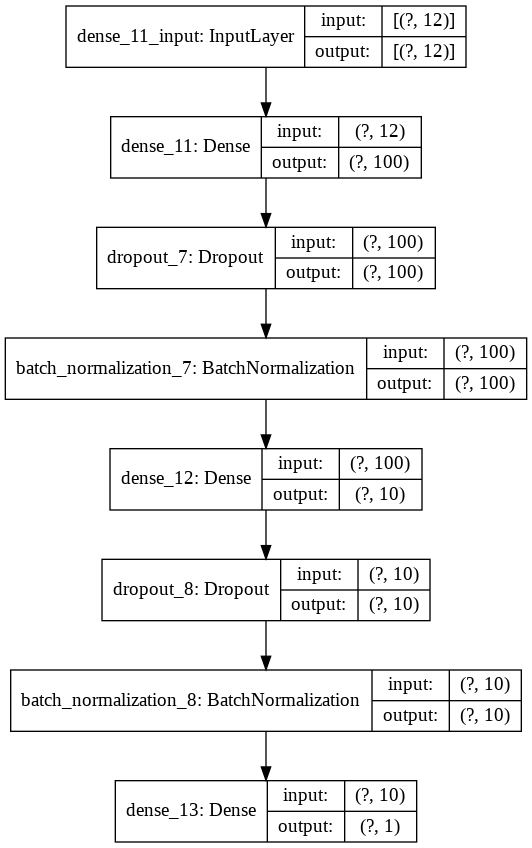

In [57]:
# Esta es una funcion generica que arma una red neuronal en base a los parametros.
# Si queremos 2 capas, nl=2 y luego la cnatidad de neuronas la primer capa con nn1 y nn2
# l1 y l2 son los regularizadores

from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV,KFold
from keras.utils import plot_model
from IPython.display import Image
import keras

!pip install pydot
!pip install graphviz

def create_model(input_shape,nl=1,nn1=1000, nn2=500, nn3 = 200, l1=0.01, l2=0.01,
                 dropout=0,batch=1):

    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()

    for i,n in zip(list(range(nl)),[nn1,nn2,nn3]):   
        model.add(Dense(n, input_dim=input_shape, activation="relu", kernel_regularizer=reg))

        if dropout!=0:
            model.add(Dropout(dropout))
            
        if batch == 1:
            model.add(BatchNormalization())
        
    model.add(Dense(1))
    model.compile(loss='mae', optimizer="adam", metrics=["mae"])
    return model

# Probemos un dummy a ver que esta pasando cuando cambiamos parametros
model = create_model(input_shape = X_train.shape[1],nl = 2,nn1=100, nn2=10,dropout=0.5)

plot_model(model, show_shapes=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [ ]:
# Hecho a mano. Esto es = create_model(input_shape = X_train.shape[1],nl = 2,nn1=100, nn2=10,dropout=0.5)
reg = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

model = Sequential()

model.add(Dense(100, input_dim=X_train.shape[1], activation="relu", kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(10, input_dim=X_train.shape[1], activation="relu", kernel_regularizer=reg))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(1))
model.compile(loss='mae', optimizer="adam", metrics=["mae"])

plot_model(model, show_shapes=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [67]:
from keras.callbacks import EarlyStopping

# Llamamos al wrapper para poder entrar al ecosistema sklearn
model = KerasRegressor(build_fn=create_model, batch_size=64, epochs=20, # batch size: Cuanto mas grande le numero mas rapido pero necesitamos volumen para poder mover libremente, asi que en este caso 64 esta bien. epochs 20 para no esperar mucho
                            verbose=2)

# Configuramos el early stoping. Le decimos que cuando vea un desvio de 0.01 en 5 pasos, que corte
es = EarlyStopping(monitor='val_loss',
                   min_delta=0.1, 
                     patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

In [65]:
# numbers of layers
nl = [1,2,3]

# neurons in each layer
nn1=[32,50,100, 200,300,400]
nn2=[15,30,50,100,200]
nn3=[15,30,50]

# dropout and regularisation
dropout = [0,0.5]
batch = [0,1]
l1 = [0, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.01, 0.003, 0.001,0.0001]

# dictionary summary
param_grid = dict(
                    nl=nl, nn1=nn1, nn2=nn2, nn3=nn3,
                    l1=l1, l2=l2, dropout=dropout,batch = batch,
                    input_shape = [X_train.shape[1]]
                  
                 )
print("Cantidad de parametros:",sum([len(x) for x in param_grid.values() if(type(x) != int)]))

Cantidad de parametros: 32


In [68]:
grid_NN = RandomizedSearchCV(estimator=model, cv=KFold(3), param_distributions=param_grid,
                          verbose=20,  n_iter=20, n_jobs=-1,scoring = "neg_mean_absolute_error")

grid_NN.fit(X_train,y_train, validation_split = 0.2,callbacks=[es],verbose=10)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f338d76dc50>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'batch': [0, 1], 'dropout': [0, 0.5],
                                        'input_shape': [12],
                                        'l1': [0, 0.01, 0.003, 0.001, 0.0001],
                                        'l2': [0, 0.01, 0.003, 0.001, 0.0001],
                                        'nl': [1, 2, 3],
                                        'nn1': [32, 50, 100, 200, 300, 400],
                                        'nn2': [15, 30, 50, 100, 200],
                                        'nn3': [15, 30, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_e

In [75]:
## recreo el modelo ganador para poder plotear la funcion de perdida
params = grid_NN.best_params_

model = create_model(**params)

model_hist = model.fit(X_train,
                    y_train, validation_split = 0.2,callbacks=[es],batch_size=64, epochs=50,verbose=10)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping


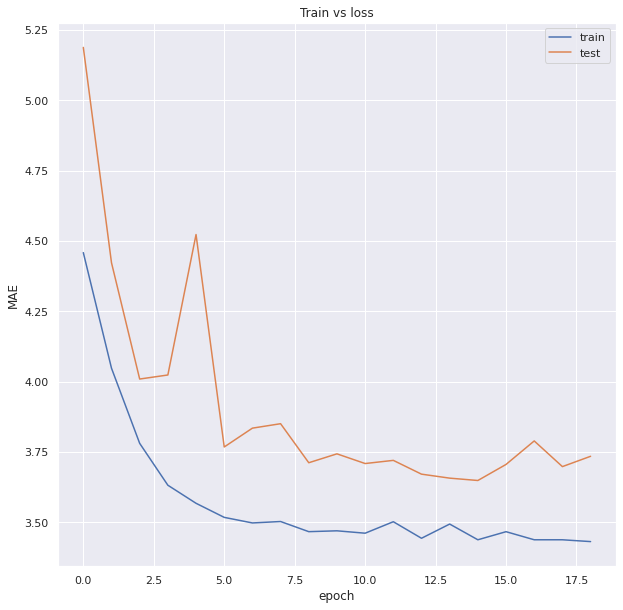

In [76]:
plt.figure(figsize = (10,10))
plt.plot(model_hist.history['mae'])
plt.plot(model_hist.history['val_mae'])
plt.title('Train vs loss')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# 4) Evaluamos los modelos

In [80]:
from sklearn.metrics import mean_absolute_error

print("MAE NN:",mean_absolute_error(y_test,grid_NN.predict(X_test)))
print("MAE Lasso:",mean_absolute_error(y_test,search_lasso.predict(X_test)))
print("MAE Ridge:",mean_absolute_error(y_test,search_ridge.predict(X_test)))

47/47 - 0s
MAE NN: 3.307148619964719
MAE Lasso: 3.578854195103564
MAE Ridge: 3.582529058483616


## Que queda por mirar?

Y si aplicamos estos modelos a cada segmento del RFM, el MAE cambiara? Claro que si! los buenos usuarios compran mas que los malos, asi que el MAE aumentara pero no necesariamente NN sea el mejor modelo para ese segmento, capaz Lasso logra captar mejor la variacion.

Otra cosa que podriamos probar para mejorar el modelo es standarizar el target ya que las redes tienen muchos problemas para la incializacion y estandarizar los datos hace que haya menos problemas con el gradiente (que el optimizador pueda encontrar un minimo en la funcion de perdida)